## Import Libraries

In [2]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from PIL import Image
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split

%matplotlib inline

## Constants

In [3]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE_new = 'SpamData/01_Processing/word-by-id-new.csv'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'


WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'


## Reading Files

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
#print(message)

<class 'str'>


In [5]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [6]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)

#print(lines)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Functions

In [7]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number**2

In [8]:
generate_squares(3)

<generator object generate_squares at 0x000001AAD353AC10>

In [9]:
for i in generate_squares(10):
    print(i, end=' --> ')

0 --> 1 --> 4 --> 9 --> 16 --> 25 --> 36 --> 49 --> 64 --> 81 --> 

In [10]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')
            is_body =  False
            lines = []
            
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
                    
            stream.close()
            
            email_body = '\n'.join(lines)
            yield file_name, email_body

In [11]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [12]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))

spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [13]:
spam_emails.shape

(1898, 2)

In [14]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))

ham_emails.head()
ham_emails.shape

(3901, 2)

In [15]:
ham_emails.head()


,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [16]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.shape

Shape of entire dataframe is  (5799, 2)


(5799, 2)

In [17]:
data.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [18]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


## Data Cleaning: Checking for missing values

In [19]:
# Check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [20]:
(data.MESSAGE.str.len() == 0).any()

True

In [21]:
(data.MESSAGE.str.len() == 0).sum()

3

In [22]:
# To check the number of entries with null/None values
data.MESSAGE.isnull().sum()

0

In [23]:
data[(data.MESSAGE.str.len() == 0)].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

## Remove System File Entries from Dataframe

In [24]:
#Method 1:
data = data.drop(['cmds'])

In [25]:
#Method 2:
#data.drop(['cmds'], inplace=True)

In [26]:
data.shape

(5796, 2)

In [27]:
document_ids = range(0, len(data.index))

In [28]:
data['DOC_ID'] = document_ids

In [29]:
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [30]:
data['FILE_NAME'] = data.index

In [31]:
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [32]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


## Save to File using Pandas

In [33]:
data.to_json(DATA_JSON_FILE)

In [34]:
DATA_JSON_FILE

'SpamData/01_Processing/email-text-data.json'

## Number of spam messages visualized (Pie Charts)

In [35]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [36]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

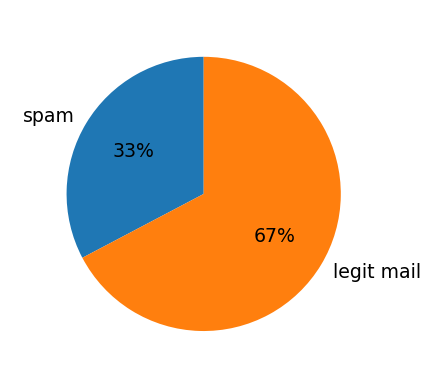

In [37]:
category_names = ['spam', 'legit mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%')
plt.show()

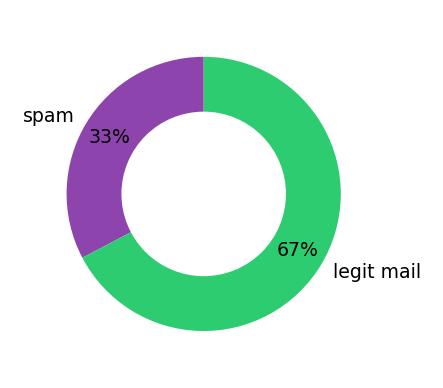

In [38]:
category_names = ['spam', 'legit mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#8e44ad', '#2ecc71']
offset = [0.05, 0.05, 0.05]

plt.figure(figsize=(2,2), dpi=227)
# plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%', colors=custom_colors, explode=[0,0.1])
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

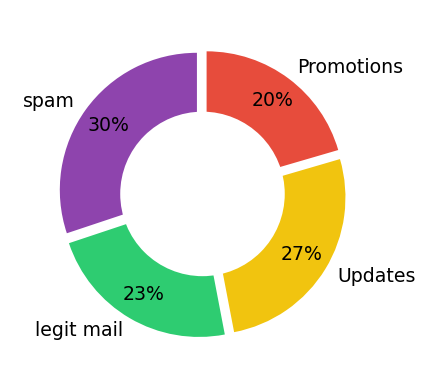

In [39]:
category_names = ['spam', 'legit mail', 'Updates', 'Promotions']
sizes = [25, 19, 22, 17]
custom_colors = ['#8e44ad', '#2ecc71', '#f1c40f', '#e74c3c']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2,2), dpi=227)
# plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%', colors=custom_colors, explode=[0,0.1])
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8, explode=offset)

# draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()


# Natural Language Processing
### Text Pre-processing

In [40]:
# Convert to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

## Download the NLTK Resources (Tokenizer & Stopwords)

In [41]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [42]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [43]:
nltk.download('shakespeare')

[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

### Tokenizing

In [44]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

### Removing stopwords

In [45]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
stop_words = set(stopwords.words('english'))

In [47]:
def stp_wrd(x):
    if 'hello' in x:
        print('Yaaay!!!')
    else:
        print('Nah!!!')

In [48]:
stp_wrd(stop_words)

Nah!!!


In [49]:
def stp_wrd_not(x):
    if 'hello' not in x:
        print('Yaaay!!!')
    else:
        print('Nah!!!')

In [50]:
stp_wrd_not(stop_words)

Yaaay!!!


In [51]:
# Lets tokenize, remove stop words, and convert a sentence to lower case

msg = 'All work and no play makes Jack a dull boy. To be or not to be'
words = word_tokenize(msg.lower())

In [52]:
words

['all',
 'work',
 'and',
 'no',
 'play',
 'makes',
 'jack',
 'a',
 'dull',
 'boy',
 '.',
 'to',
 'be',
 'or',
 'not',
 'to',
 'be']

In [53]:
filtered_words = []
not_in_filtered_words = []
# Challenge: append non-stop words to filtered words
msg = 'All work and no play makes Jack a dull boy. To be or not to be'
our_words = word_tokenize(msg.lower())
stop_words = set(stopwords.words('english'))

stop_words = np.array(list(stop_words))
our_words = np.array(our_words)

#stop_words = list(stop_words)

for i in range(len(our_words)):
    if our_words[i] not in stop_words:
        filtered_words.append(our_words[i])
    else:
        not_in_filtered_words.append(our_words[i])
        
filtered_words = np.array(filtered_words)
not_in_filtered_words = np.array(list(set(not_in_filtered_words)))

In [54]:
not_in_filtered_words.shape

(8,)

In [55]:
our_words = np.array(our_words)

In [56]:
len(our_words)

17

In [57]:
not_in_filtered_words.shape

(8,)

In [58]:
filtered_words

array(['work', 'play', 'makes', 'jack', 'dull', 'boy', '.'], dtype='<U5')

In [59]:
filtered_words.shape

(7,)

## Word Stems and Stemming

In [60]:
filtered_words = []
not_in_filtered_words = []
# Challenge: append non-stop words to filtered words
msg = 'All work and no play makes Jack a dull boy. To be or not to be. Nobody expects the Spanish Inquisition!'
our_words = word_tokenize(msg.lower())
stop_words = set(stopwords.words('english'))

stop_words = np.array(list(stop_words))
our_words = np.array(our_words)
#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')
#stop_words = list(stop_words)

for i in range(len(our_words)):
    if our_words[i] not in stop_words:
        stemmed_word = stemmer.stem(our_words[i])
        filtered_words.append(stemmed_word)
    else:
        not_in_filtered_words.append(our_words[i])
        
filtered_words = np.array(filtered_words)
not_in_filtered_words = np.array(list(set(not_in_filtered_words)))

In [61]:
filtered_words

array(['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi',
       'expect', 'spanish', 'inquisit', '!'], dtype='<U8')

## Removing Punctuation

In [62]:
filtered_words = []
not_in_filtered_words = []
# Challenge: append non-stop words to filtered words
msg = 'All work and no play makes Jack a dull boy. To be or not to be. Nobody expects the Spanish Inquisition!'
our_words = word_tokenize(msg.lower())
stop_words = set(stopwords.words('english'))

stop_words = np.array(list(stop_words))
our_words = np.array(our_words)
#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')
#stop_words = list(stop_words)

#for i in range(len(our_words)):
#    if our_words[i] not in stop_words:
#        stemmed_word = stemmer.stem(our_words[i])
#        if stemmed_word.isalpha():
#            filtered_words.append(stemmed_word)
#        else:
#            not_in_filtered_words.append(our_words[i])
            
for i in range(len(our_words)):
    if our_words[i] not in stop_words and our_words[i].isalpha():
        stemmed_word = stemmer.stem(our_words[i])
        filtered_words.append(stemmed_word)
    else:
        not_in_filtered_words.append(our_words[i])
    
        
filtered_words = np.array(filtered_words)
not_in_filtered_words = np.array(list(set(not_in_filtered_words)))

In [63]:
'p'.isalpha()

True

In [64]:
filtered_words

array(['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect',
       'spanish', 'inquisit'], dtype='<U8')

In [65]:
not_in_filtered_words

array(['all', 'to', 'be', 'not', 'or', 'a', '!', 'the', '.', 'no', 'and'],
      dtype='<U3')

## Removing HTML tags from Emails

In [66]:
soup = BeautifulSoup(data.at[0, 'MESSAGE'], 'html.parser')
#print(soup.prettify())

In [67]:
# soup.get_text()

## Functions for Email Processing

In [68]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [69]:
# clean_message(email_body)

In [70]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    
    soup = BeautifulSoup(message, 'html.parser')
    soup = soup.get_text()
    words = soup

    
    # Converts to Lower case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            #filtered_words.append(word)
    
    return filtered_words

In [71]:
clean_msg_no_html(data.at[1, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'ilug',
 'irish',
 'linux',
 'user',
 'group',
 'ilug',
 'http',
 'un',
 'subscript',
 'inform',
 'list',
 'maintain',
 'listmast']

# Slicing Dataframes and Series & Creating Subsets

In [72]:
data.iat[2,0]

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [73]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,Help wanted. We are a 14 year old fortune 500...,1,00007.d8521faf753ff9ee989122f6816f87d7
7,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,1,00008.dfd941deb10f5eed78b1594b131c9266
8,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,1,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",1,00010.445affef4c70feec58f9198cfbc22997
10,Cellular Phone Accessories All At Below Wholes...,1,00011.61816b9ad167657773a427d890d0468e


In [74]:
data.MESSAGE.iloc[5:11]

DOC_ID
5     A POWERHOUSE GIFTING PROGRAM You Don't Want To...
6     Help wanted.  We are a 14 year old fortune 500...
7     <html>\n\n<head>\n\n<title>ReliaQuote - Save U...
8     TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...
9     Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...
10    Cellular Phone Accessories All At Below Wholes...
Name: MESSAGE, dtype: object

In [75]:
first_emails = data.MESSAGE.iloc[0:10]
first_emails.head()

nested_list = first_emails.apply(clean_message)
nested_list

DOC_ID
0    [doctyp, html, public, html, html, head, meta,...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
5    [powerhous, gift, program, want, miss, get, fo...
6    [help, want, year, old, fortun, compani, grow,...
7    [html, head, titl, reliaquot, save, life, insu...
8    [tire, bull, want, stop, lose, money, want, re...
9    [dear, html, bodi, center, b, font, color, red...
Name: MESSAGE, dtype: object

In [76]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

### OR
flat_list = [item for sublist in nested_list for item in sublist]
 
len(flat_list)

1853

In [77]:
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [78]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, skip, write, jeremi, put...
5794    [mark, hammond, mhammond, like, given, zodb, s...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

## Using Logic to Slice DataFrames

In [79]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [80]:
data[data.CATEGORY == 1].head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [81]:
# Challenge: create two variables (doc_ids_spam, doc_ids_ham) which
# hold onto the indices for the spam and the non-spam emails respectively

doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [82]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

## Subsetting a Series with an index

In [83]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [84]:
print(type(doc_ids_spam))

<class 'pandas.core.indexes.numeric.Int64Index'>


In [85]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_spam = nested_list.loc[doc_ids_spam]

In [86]:
nested_list_spam.shape

(1896,)

In [87]:
# challenge: use Python list comprehension to find the total number of 
# words in our cleaned dataset of spam email bodie. Also find the total number of 
# words in normal emails in the dataset. Then find the 10 most common words used in
# spam. Also, find the 10 most common words in non-spam messages

In [88]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0]  ###Total number of unique words for 'ham' msg

20972

In [89]:
normal_words[:10]

http      7961
use       3640
list      2888
one       2379
get       2289
mail      2259
would     2005
like      1932
messag    1857
work      1800
dtype: int64

In [90]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0]   ###Total number of unique words in the spam messages

13945

In [91]:
spammy_words[:10]

font      20520
br        19865
nbsp      11254
http      10715
td        10654
b          7447
p          7239
arial      6631
tr         6365
center     4724
dtype: int64

## Creating a Word Cloud

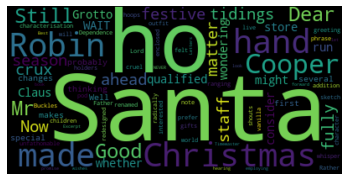

In [92]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [93]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [94]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [95]:
word_list = [''.join(word) for word in example_corpus]

In [96]:
type(word_list)

list

In [97]:
novel_as_string = ' '.join(word_list)

In [98]:
type(novel_as_string)

str

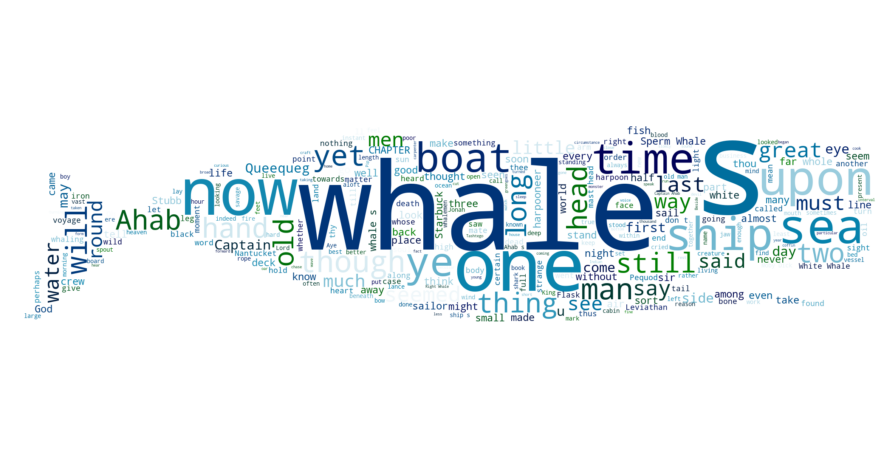

In [99]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=300, colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [100]:
rgb_array.shape

(1024, 2048, 3)

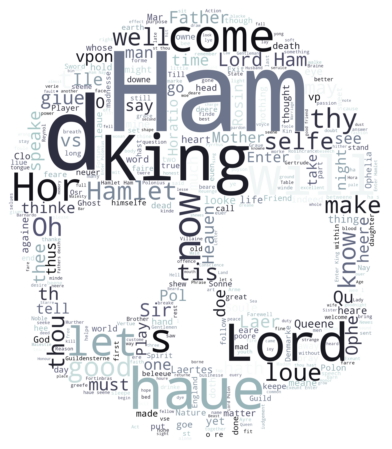

In [101]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list_hamlet = [''.join(word) for word in hamlet_corpus]
hamlet_novel_as_string = ' '.join(word_list_hamlet)

icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=400, colormap='bone')
word_cloud.generate(hamlet_novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#len(hamlet_corpus)

## Word cloud of Ham and Spam Messages

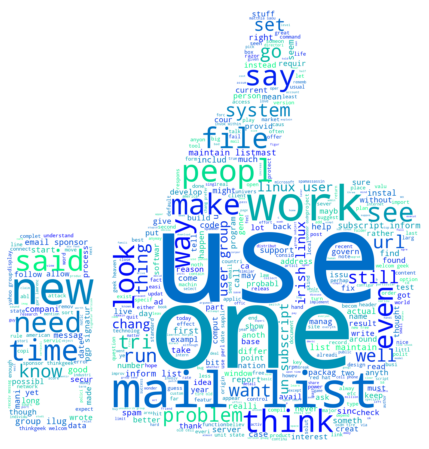

In [102]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=500, colormap='winter')
word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

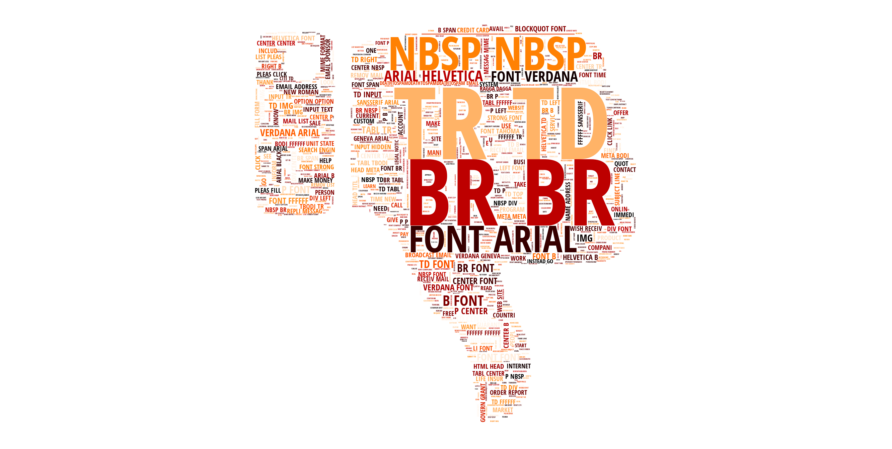

In [103]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                      max_words=1000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)
word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate Vocabulary & Dictionary

In [104]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [105]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words', unique_words.shape[0])
unique_words.head()

Number of unique words 27975


font    20755
br      20096
http    18676
nbsp    11420
td      10737
dtype: int64

In [106]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 font     20755
br       20096
http     18676
nbsp     11420
td       10737
b         7613
p         7463
arial     6688
tr        6430
use       5037
dtype: int64


In [107]:
type(frequent_words)

pandas.core.series.Series

## Create Vocabulary DataFrame with WORD_ID

In [108]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,font
1,br
2,http
3,nbsp
4,td


## Save the vocabulary as a CSV file

In [109]:
vocab.to_csv(WORD_ID_FILE_new, index=vocab.index.name, header=vocab.VOCAB_WORD.name)
vocab_new = pd.read_csv(WORD_ID_FILE)

In [110]:
'brewer' in set(vocab.VOCAB_WORD)

False

## Exercise: Find the Email with the most number of words

In [111]:
# Challenge: 
# Print out the numer of words in the longest email (after cleaning and stemming) 
# Note the longest email's position in the list of cleaned emails. 
# Print out the stemmed list of words in the longest email. 
# Print out the longest email from the data - dataframe

# Hint: Use the len() function and practice list comprehension

In [112]:
# For loop:
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))
print('The number of words in the longest email: ', max(clean_email_lengths))

The number of words in the longest email:  7719


In [113]:
# Python List Comprehension:
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('The number of words in the longest email: ', max(clean_email_lengths))

# Position of this email:
print('The position of this email on th list (and data dataframe) is: ', np.argmax(clean_email_lengths))

# Find out the words in this email:
#stemmed_nested_list[np.argmax(clean_email_lengths)]

# Original email after removing the header:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

The number of words in the longest email:  7719
The position of this email on th list (and data dataframe) is:  5775


'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate features & a Sparse Matrix
### Creating a DataFrame with one word per column 

In [114]:
type(stemmed_nested_list[2])

list

In [165]:
#stemmed_nested_list.to_list()

In [116]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.to_list())

In [117]:
word_columns_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,7709,7710,7711,7712,7713,7714,7715,7716,7717,7718
5791,http,bizarr,collect,stuf,anim,could,fetch,sold,cornwal,museum,...,None,None,None,None,None,None,None,None,None,None
5792,care,use,one,also,realli,cute,thing,japanes,av,girl,...,None,None,None,None,None,None,None,None,None,None
5793,sm,skip,montanaro,skip,write,jeremi,put,anoth,way,interest,...,None,None,None,None,None,None,None,None,None,None
5794,mark,hammond,mhammond,like,given,zodb,sound,attract,would,packag,...,None,None,None,None,None,None,None,None,None,None
5795,hi,probabl,use,whatsoev,also,problem,regard,nvidia,two,machin,...,None,None,None,None,None,None,None,None,None,None


In [118]:
word_columns_df.shape

(5796, 7719)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [120]:
print('Nr of training samples: ', X_train.shape[0])

Nr of training samples:  4057


In [121]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7709,7710,7711,7712,7713,7714,7715,7716,7717,7718
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,chad,sven,sven,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [122]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7709,7710,7711,7712,7713,7714,7715,7716,7717,7718
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [123]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

## Create a sparse Matrix for the training data

In [124]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [125]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe
    
    df: A dataframe with words in the columns with a document id
    as an index (X_train or X_test) 
    
    indexed_words: index of words ordered by word id
    
    labels: category as a series (y_train or y_test)
    
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)

In [126]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 10min 21s


In [127]:
sparse_train_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,266
1,0,4844,1,1313
2,0,4844,1,539
3,0,4844,1,356
4,0,4844,1,282


In [128]:
sparse_train_df.tail()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
543275,1,860,1,1281
543276,1,860,1,40
543277,1,860,1,33
543278,1,860,1,2
543279,1,860,1,153


In [129]:
sparse_train_df.shape

(543280, 4)

## Combine occurences with the Pandas groupby() Method

In [130]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              9
       1       1             35
       2       1              1
       4       1              6
       5       1              3

In [131]:
vocab.at[5, 'VOCAB_WORD']

'b'

In [132]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [133]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,9
1,0,1,1,35
2,0,2,1,1
3,0,4,1,6
4,0,5,1,3


In [134]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
273262,5795,2124,0,2
273263,5795,2130,0,1
273264,5795,2135,0,1
273265,5795,2368,0,1
273266,5795,2469,0,1


In [135]:
vocab.at[1923, 'VOCAB_WORD']

'phrase'

In [136]:
data.MESSAGE[5795]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

In [137]:
train_grouped.shape

(273267, 4)

### Save Training Data as .txt File

In [138]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [139]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [140]:
# Challenge: Create a sparse matrix for the test data. Group the occurences of the smae word in the same emai. Then save the data as a .txt file

X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7709,7710,7711,7712,7713,7714,7715,7716,7717,7718
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [141]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [142]:
X_test.shape

(1739, 7719)

In [143]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 4min 48s


In [144]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [145]:
sparse_test_df.shape

(250942, 4)

In [147]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,11,1,1
1,8,12,1,4
2,8,13,1,2
3,8,15,1,1
4,8,16,1,2


In [148]:
test_grouped.shape

(123920, 4)

In [149]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

## Pre-Processing Subtleties and checking our understanding

In [150]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [151]:
len(test_doc_ids)

1726

In [152]:
len(X_test)

1739

In [153]:
set(X_test.index.values) - test_doc_ids 

{134, 179, 240, 274, 298, 339, 439, 471, 670, 945, 1544, 1670, 1700}

In [159]:
data.MESSAGE[134]

'------=_NextPart_000_00E8_85C13B1D.B7243B86\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPGh0bWw+DQoNCjxib2R5IGJnY29sb3I9IiNGRkZGRkYiIHRleHQ9IiMwMDAw\n\nMDAiPiANCjxwIGFsaWduPSJjZW50ZXIiPjxhIGhyZWY9Imh0dHA6Ly93d3cu\n\nZGlyZWN0d2Vic3RvcmUuY29tL3RveXMvaW5kZXguaHRtbCI+PGltZyBzcmM9\n\nImh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL21waWMuanBnIiB3aWR0\n\naD0iNTAwIiBoZWlnaHQ9IjMzOSIgYm9yZGVyPSIwIj48L2E+PGJyPiANCjxm\n\nb250IHNpemU9IjMiIGZhY2U9IkFyaWFsLCBIZWx2ZXRpY2EsIHNhbnMtc2Vy\n\naWYiPjxhIGhyZWY9Imh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL3Rv\n\neXMvaW5kZXguaHRtbCI+PGI+RU5URVIgDQpOT1cgaWYgeW91IGFyZSAxOCBh\n\nbmQgb3ZlcjwvYj48L2E+PC9mb250PjwvcD4gDQo8cCBhbGlnbj0iY2VudGVy\n\nIj48Zm9udCBmYWNlPSJBcmlhbCwgSGVsdmV0aWNhLCBzYW5zLXNlcmlmIiBz\n\naXplPSI0IiBjb2xvcj0iI0ZGMDAwMCI+PGI+U1BFQ0lBTCANCk9GRkVSPGJy\n\nPiANCjxmb250IHNpemU9IjUiPjMwIERheXMgPGk+RlJFRSBhY2Nlc3M8L2k+\n\nIDwvZm9udD48YnI+IA0KdG8gdGhlIGxhcmdlc3QgQWR1bHRzaXRlIG9uIHRo\n\nZSB3ZWIuPGJyPiANCjwvYj4gPG

In [160]:
data.loc[134]

MESSAGE      ------=_NextPart_000_00E8_85C13B1D.B7243B86\n\...
CATEGORY                                                     1
FILE_NAME               00135.00e388e3b23df6278a8845047ca25160
Name: 134, dtype: object

In [163]:
clean_msg_no_html(data.at[134, 'MESSAGE'])

[]

In [164]:
clean_message(data.at[134, 'MESSAGE'])

[]